# Trajectories Clustering and Analysis

### Goal of this Notebook
Parsing and clustering the avaiable trajectory data and analyzing aggregate measurements.
***
**Outputs:**
- TRAJECTORIES.HTML [Manually Made] KeplerGl Interactive Interface File, pre-configured to load with Trajectories layers and spatial clustering.

**Inputs:**
- _trajectories.csv_ from raw trajectories data. Available on Dropbox in `/Private Structured data collection/Data processing/Auxiliary files/Demand/Flow_speed/Trajectories`.
- _trajectories_clusterd.csv_ from raw trajectories data. Available on Dropbox in `/Private Structured data collection/Data processing/Auxiliary files/Demand/Flow_speed/Trajectories`.
- _InternalCentroidZones.shp_ Shapefile available on Dropbox in `/Private Structured data collection/Data processing/Raw/Demand/OD demand/TAZ`
- _ExternalCentroidZones.shp_ Shapefile available on Dropbox in `/Private Structured data collection/Data processing/Raw/Demand/OD demand/TAZ`

**Temporary Files Within the Pipeline:** 
- No temporary files.

**Dependent Scripts:**
- No script dependencies.

**Dependent Libraries:**
- numpy
- pandas
- os
- csv
- json
- geopy
- matplotlib
- gmplot
- dipy
- shapely
- keplergl
- geopandas
- rtree
***
**Sections:**
- A. [Parse Raw Trajectory Data](#section_ID_a)
- B. [Clustering](#section_ID_b)
- C. [Plotting, Mapping & Analysis](#section_ID_c)

# To dos
0. Discuss with Michal about the way you did the clustering, as it might be helpful for him to reuse some of your code.
1. Use the module fremont dropbox to get the folders from the dropbox (see next cell)  **DONE**
2. Create both files trajectories and trajectories condensed in the current iPython notebook.  **DONE**
    - Put them in `/Private Structured data collection/Data processing/Auxiliary files/Demand/Flow_speed/Trajectories`
3. Use the external and internal TAZs instead of the sklearn clustering to cluster the trajectories depending on their origin and destination  **DONE**
    - TAZ are shapefiles in `Private Structured data collection/Data processing/Raw/Demand/OD demand/TAZ`
4. Write a function that takes as input the ids of the origin and destination TAZ and output the corresponding trajectories using Kepler.gl  **DONE**
5. Remove `trajectories.csv` and `trajectories_condensed.csv` from GitHub (they are under NDA) **DONE**
6. Generate all Kepler.gl maps in `/Private Structured data collection/Data processing/Temporary exports to be copied to processed data/Trajectories` **DONE**

### To do later
7. Match paths to road sections (see Jane McFarlan for that)
8. For every O-D pairs (where O and D are TAZ id), and 15 minutes time step output the corresponding paths used by drivers
9. Compare the paths used by drivers using Here data, with the ones used by drivers in Aimsun simulations.
10. For the path going from South of I-680N to North of I-680N, deduces the percentage of drivers using local roads instead of staying on the Highway for different time of the day

In [1]:
import sys
import os

# We let this notebook to know where to look for fremontdropbox module
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from fremontdropbox import get_dropbox_location

dropbox_dir = get_dropbox_location()

rootdir = dropbox_dir + "/Private Structured data collection/Data processing/Raw/Demand/Flow_speed/Here data"
print(rootdir)

'\nimport sys\nimport os\n\n# We let this notebook to know where to look for fremontdropbox module\nmodule_path = os.path.abspath(os.path.join(\'../..\'))\nif module_path not in sys.path:\n    sys.path.append(module_path)\n\nfrom fremontdropbox import get_dropbox_location\n\ndropbox_dir = get_dropbox_location()\n\nrootdir = dropbox_dir + "/Private Structured data collection/Data processing/Raw/Demand/Flow_speed/Here data"\nprint(rootdir)\n'

In [2]:
import os
import csv
import json
import rtree
import numpy as np
import pandas as pd
import geopy.distance
import geopandas as gpd
import matplotlib.pyplot as plt

from gmplot import gmplot
from sklearn import metrics
from keplergl import KeplerGl
from sklearn.cluster import DBSCAN
from dipy.segment.metric import Metric
from dipy.segment.metric import ResampleFeature
from dipy.segment.clustering import QuickBundles
from shapely.geometry import Point, LineString, MultiPoint
from geopy.distance import great_circle

<a id="section_ID_a"></a>
## A. Parse Raw Trajectory Data into Singular CSV

In [3]:
def parseTrajectories(filename, rootdir, condensed):
    counter = 0
    with open(filename, 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        if (condensed):
            writer.writerow(["Start Time", "End Time", "Origin X", "Origin Y", "Dest X", "Dest Y", "Source"])
        else:
            writer.writerow(["Time", "Speed", "Heading", "Origin X", "Origin Y", "Dest X", "Dest Y", "Source"])

        for subdir, dirs, files in os.walk(rootdir):
            for file in files:
                counter += 1
                path = os.path.join(subdir, file)

                if (not path == "./step_019_organize_by_provider\.ipynb_checkpoints\Test_python-checkpoint.ipynb"):

                    with open(path) as f:
                        data = json.load(f)

                    if (condensed):
                        start, end = data['features'][0], data['features'][-1]

                        trajectory = [start['properties']['time'], end['properties']['time'], start['geometry']['coordinates'][0][0],\
                                        start['geometry']['coordinates'][0][1], end['geometry']['coordinates'][1][0],\
                                        end['geometry']['coordinates'][1][1], os.path.basename(path).split(".")[0]]

                        writer.writerow(trajectory)
                    else:
                        for feature in data['features']:

                            trajectory = [feature['properties']['time'], feature['properties']['speed'], feature['properties']['heading'],\
                                            feature['geometry']['coordinates'][0][0], feature['geometry']['coordinates'][0][1],\
                                            feature['geometry']['coordinates'][1][0], feature['geometry']['coordinates'][1][1], os.path.basename(path).split(".")[0]]

                            writer.writerow(trajectory)
                        # print(trajectory)

        print("All trajectory data has been parsed to {0}. {1} files total.".format(filename, counter))

In [4]:
parseTrajectories('trajectories.csv', './step_019_organize_by_provider', False) # change .step.... to rootdir for DB
parseTrajectories('trajectories_condensed.csv', './step_019_organize_by_provider', True) # change .step.... to rootdir for DB

All trajectory data has been parsed to trajectories.csv. 3140 files total.
All trajectory data has been parsed to trajectories_condensed.csv. 3140 files total.


<a id="section_ID_b"></a>
## B. Density Based Spatial Clustering of Applications with Noise (DB-SCAN) 
### _NOTE: DEPRECATED FOR TRAJECTORIES. HERE FOR REFERENCE IN OTHER APPLICATIONS_

In [5]:
class DensityCluster:  
    
    def __init__(self, data_input):
        self.df = pd.read_csv(data_input)
        self.maxes = []
        self.rep_points = []
        self.clusters = []
        self.numClusters = 0
        
    def createClusters(self, tuning_parameter=0.1):
        # represent GPS points as (lat, lon)
        coords = self.df.as_matrix(columns=['Origin Y', 'Origin X'])
        # earth's radius in km
        kms_per_radian = 6371.0088
        # define epsilon as 0.1 kilometers, converted to radians for use by haversine
        epsilon = tuning_parameter / kms_per_radian

        # eps is the max distance that points can be from each other to be considered in a cluster
        # min_samples is the minimum cluster size (everything else is classified as noise)
        db = DBSCAN(eps=epsilon, min_samples=100, algorithm='ball_tree', metric='haversine').fit(np.radians(coords))
        cluster_labels = db.labels_
        # get the number of clusters (ignore noisy samples which are given the label -1)
        self.numClusters = len(set(cluster_labels) - set([-1]))

        print ('Clustered ' + str(len(self.df)) + ' points to ' + str(self.numClusters) + ' clusters')

        # turn the clusters in to a pandas series
        self.clusters = pd.Series([coords[cluster_labels == n] for n in range(self.numClusters)])

    def getCentermostPoint(self, cluster):
        centroid = (MultiPoint(cluster).centroid.x, MultiPoint(cluster).centroid.y)
        centermost_point = min(cluster, key=lambda point: great_circle(point, centroid).m)
        return tuple(centermost_point)
    
    def showCentroidClusters(self):
        # get the centroid point for each cluster
        centermost_points = self.clusters.map(self.getCentermostPoint)
        lats, lons = zip(*centermost_points)

        self.rep_points = pd.DataFrame({'lon':lons, 'lat':lats})
        fig, ax = plt.subplots(figsize=[15, 10])

        rs_scatter = ax.scatter(self.rep_points['lon'][0], self.rep_points['lat'][0], c='#99cc99', edgecolor='None', alpha=0.7, s=self.maxes[0]/10)

        for i in range(1, self.numClusters):
            ax.scatter(self.rep_points['lon'][i], self.rep_points['lat'][i], c='#99cc99', edgecolor='None', alpha=0.7, s=self.maxes[i]*2)

        df_scatter = ax.scatter(self.df['Origin X'], self.df['Origin Y'], c='k', alpha=0.9, s=3)

        ax.set_title('Full GPS trace vs. DBSCAN clusters')
        ax.set_xlabel('Longitude')
        ax.set_ylabel('Latitude')
        ax.legend([df_scatter, rs_scatter], ['GPS Points', 'Cluster Centers'], loc='upper right')

        labels = ['Cluster {0}'.format(i) for i in range(1, self.numClusters + 1)]
        for label, x, y in zip(labels, self.rep_points['lon'], self.rep_points['lat']):
            plt.annotate(
                label, 
                xy = (x, y), xytext = (-25, -30),
                textcoords = 'offset points', ha = 'right', va = 'bottom',
                bbox = dict(boxstyle = 'round,pad=0.5', fc = 'white', alpha = 0.5),
                arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0'))

        plt.show()
        
    def groupByTime(self, row):
        t = self.df[(self.df['Origin Y']==row[0]) & (self.df['Origin X']==row[1])]['Time'].iloc[0]
        return t[ (t[:t.index(':')].index(" ")):][0:3]
    
    def showTimeClusters(self):
        M = []
        for i in range(self.numClusters):
            hours = np.apply_along_axis(self.groupByTime, 1, self.clusters[i]).tolist()
            M.append(list(map(int, hours)))
 
        f, axarr = plt.subplots(len(M), figsize=(12.5,50))
        for i in range(len(M)):
            y, x, _ = axarr[i].hist(list(M[i]))
            self.maxes.append(y.max())
            axarr[i].set_title("Cluster {0}".format(i + 1))
            axarr[i].set_xlabel("Hour")
            axarr[i].set_ylabel("Trajectories")
        f.tight_layout(pad=1.0)
        
    def gmapPlot(self):
        gmap = gmplot.GoogleMapPlotter(self.df["Origin Y"][0], self.df["Origin X"][0], 11)
        gmap.plot(self.df["Origin Y"], self.df["Origin X"], "cornflowerblue", edge_width=1)
        gmap.draw("trajectories_map.html")
        print("Plotted trajectories.")

        gmap = gmplot.GoogleMapPlotter(self.df["Origin Y"][0], self.df["Origin X"][0], 11)
        gmap.plot(self.df["Origin Y"], self.df["Origin X"], "cornflowerblue", edge_width=1)
        gmap.heatmap(self.rep_points['lat'], self.rep_points['lon'], radius=20)
        gmap.draw("trajectories_map_with_clusters.html")
        print("Plotted trajectories with clusters.")

        gmap = gmplot.GoogleMapPlotter(self.df["Origin Y"][0], self.df["Origin X"][0], 11)
        gmap.heatmap(self.rep_points['lat'], self.rep_points['lon'], radius=20)
        gmap.draw("map_with_clusters.html")
        print("Plotted clusters.")
        
    def runAll(self):
        self.createClusters()
        self.showTimeClusters()
        self.showCentroidClusters()


C:\Users\jainc\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  if sys.path[0] == '':


Clustered 50201 points to 22 clusters


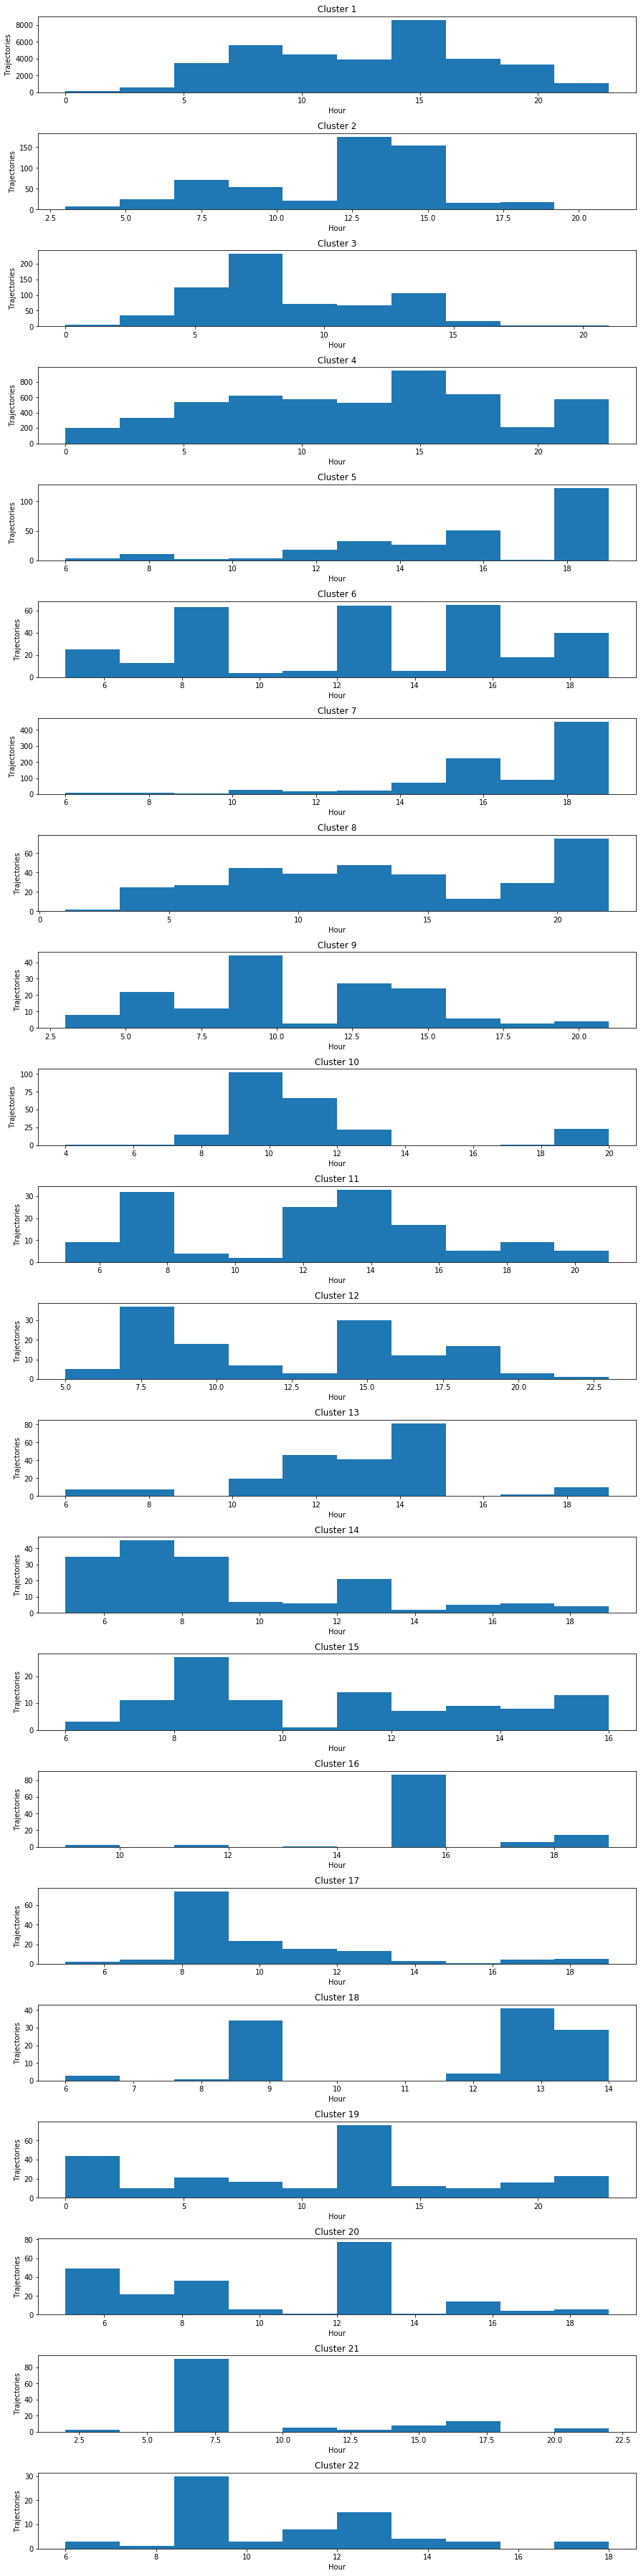

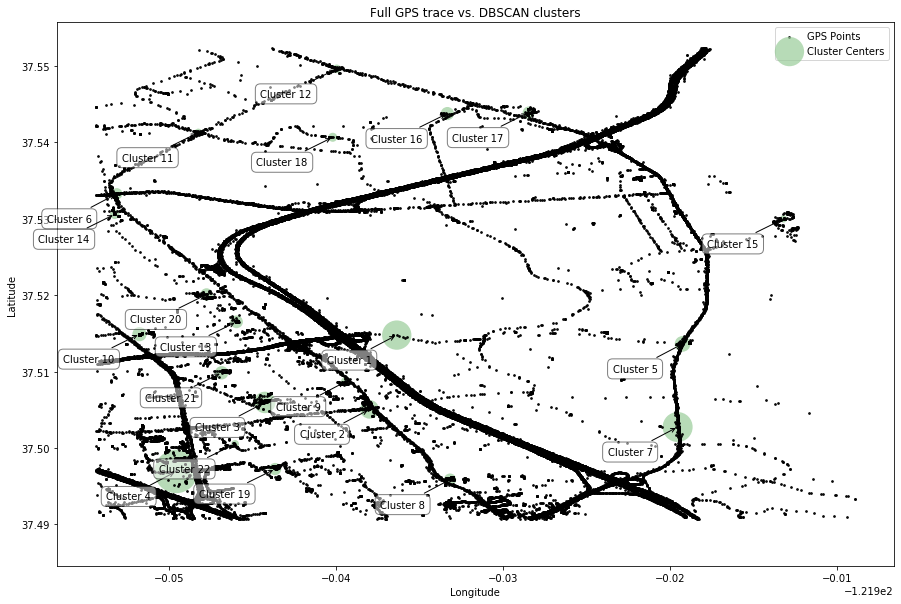

In [6]:
dc = DensityCluster("trajectories.csv")
dc.runAll()

<a id="section_ID_c"></a>
## C. Plotting, Mapping, and Analysis

In [7]:
def clusterByZone(trajectories, zones, merge):
    # spatial join and group by to get count of incidents in each neighborhood 
    trajectories = trajectories.loc[trajectories.is_valid]
    zones = zones.loc[zones.is_valid]

    joined = gpd.sjoin(trajectories, zones, op="within")
    
    if (not merge):
        return joined
    
    grouped = joined.groupby('CentroidID').size()
    df = grouped.to_frame().reset_index()
    df.columns = ['CentroidID', 'count']
   
    merged = zones.merge(df, on='CentroidID', how='outer')
    merged['count'].fillna(0,inplace=True)
    merged['count'] = merged['count'].astype(int)
    
    return merged

int_shapefile = gpd.read_file("./TAZ/InternalCentroidZones.shp") # change ./.... to rootdir for DB
ext_shapefile = gpd.read_file("./TAZ/ExternalCentroidZones.shp") # change ./.... to rootdir for DB

df = pd.read_csv("trajectories_condensed.csv")
gdf_origins = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df['Origin X'], df['Origin Y']))

df = pd.read_csv("trajectories_condensed.csv")
gdf_dests = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df['Dest X'], df['Dest Y']))

int_trajectories_origins = clusterByZone(gdf_origins, int_shapefile, merge=True)
int_trajectories_dests = clusterByZone(gdf_dests, int_shapefile, merge=True)

ext_trajectories_origins = clusterByZone(gdf_origins, ext_shapefile, merge=True)
ext_trajectories_dests = clusterByZone(gdf_dests, ext_shapefile, merge=True)

C:\Users\jainc\Anaconda3\lib\site-packages\geopandas\tools\sjoin.py:61: UserWarning: CRS of frames being joined does not match!(None != epsg:4326)
  "(%s != %s)" % (left_df.crs, right_df.crs)
C:\Users\jainc\Anaconda3\lib\site-packages\geopandas\tools\sjoin.py:61: UserWarning: CRS of frames being joined does not match!(None != epsg:4326)
  "(%s != %s)" % (left_df.crs, right_df.crs)
C:\Users\jainc\Anaconda3\lib\site-packages\geopandas\tools\sjoin.py:61: UserWarning: CRS of frames being joined does not match!(None != epsg:4326)
  "(%s != %s)" % (left_df.crs, right_df.crs)
C:\Users\jainc\Anaconda3\lib\site-packages\geopandas\tools\sjoin.py:61: UserWarning: CRS of frames being joined does not match!(None != epsg:4326)
  "(%s != %s)" % (left_df.crs, right_df.crs)


In [16]:
df = pd.read_csv("trajectories_condensed.csv")

origin_zones_map = KeplerGl(height=500) #, config=czm_config)

origin_zones_map.add_data(data=df, name='Trajectories')
origin_zones_map.add_data(data=int_trajectories_origins, name='Origins - Internal Zones')
origin_zones_map.add_data(data=ext_trajectories_origins, name='Origins - External Zones')

origin_zones_map.save_to_html(file_name="origin_zones_map.html")
origin_zones_map

User Guide: https://github.com/keplergl/kepler.gl/blob/master/docs/keplergl-jupyter/user-guide.md
Map saved to origin_zones_map.html!


KeplerGl(data={'Trajectories': {'index': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19…

In [17]:
dests_zones_map = KeplerGl(height=500) #, config=czm_config)

dests_zones_map.add_data(data=df, name='Trajectories')
dests_zones_map.add_data(data=int_trajectories_dests, name='Destinations - Internal Zones')
dests_zones_map.add_data(data=ext_trajectories_dests, name='Destinations - External Zones')

dests_zones_map.save_to_html(file_name="dests_zones_map.html")
dests_zones_map

User Guide: https://github.com/keplergl/kepler.gl/blob/master/docs/keplergl-jupyter/user-guide.md
Map saved to dests_zones_map.html!


KeplerGl(data={'Trajectories': {'index': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19…

In [18]:
def trajectoriesFromZones(gdf_origins, gdf_dests, origin_id, dest_id):
    origins = gdf_origins.loc[gdf_origins['CentroidID'] == str(origin_id)]['Source']
    dests = gdf_dests.loc[gdf_dests['CentroidID'] == str(dest_id)]['Source']
    matches = pd.merge(origins, dests, how='inner')

    df = pd.read_csv("trajectories.csv")
    geometry = [Point(xy) for xy in zip(df['Origin X'], df['Origin Y'])]
    gdf = gpd.GeoDataFrame(df, geometry=geometry)
    gdf = gdf.groupby(['Source'])['geometry'].apply(lambda x: LineString(x.tolist()))
    gdf = gpd.GeoDataFrame(gdf, geometry='geometry')
    gdf.columns = ["Source"]

    trajectories = [gdf['Source'][match] for match in matches['Source']]
        
    return gpd.GeoDataFrame(geometry=trajectories)

def showTrajectoriesFromZones(origin_id, dest_id):
    int_shapefile = gpd.read_file("./TAZ/InternalCentroidZones.shp") # change ./.... to rootdir for DB
    ext_shapefile = gpd.read_file("./TAZ/ExternalCentroidZones.shp") # change ./.... to rootdir for DB

    df = pd.read_csv("trajectories_condensed.csv")
    gdf_origins = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df['Origin X'], df['Origin Y']))

    df = pd.read_csv("trajectories_condensed.csv")
    gdf_dests = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df['Dest X'], df['Dest Y']))

    int_trajectories_origins = clusterByZone(gdf_origins, int_shapefile, merge=False)
    int_trajectories_dests = clusterByZone(gdf_dests, int_shapefile, merge=False)
    
    matching_trajectories = trajectoriesFromZones(int_trajectories_origins, int_trajectories_dests, origin_id, dest_id)
    df = pd.read_csv("trajectories_condensed.csv")
    
    chosen_zones_map = KeplerGl(height=500)
    int_zones = clusterByZone(gdf_origins, int_shapefile, merge=True)
    chosen_zones_map.add_data(data=df, name='Trajectories')
    chosen_zones_map.add_data(data=matching_trajectories, name='Matching Trajectories')
    chosen_zones_map.add_data(data=int_zones, name='Internal Zones')
    
    chosen_zones_map.save_to_html(file_name="chosen_zones_map.html")
    return chosen_zones_map

In [15]:
showTrajectoriesFromZones(origin_id=10, dest_id=24)

C:\Users\jainc\Anaconda3\lib\site-packages\geopandas\tools\sjoin.py:61: UserWarning: CRS of frames being joined does not match!(None != epsg:4326)
  "(%s != %s)" % (left_df.crs, right_df.crs)
C:\Users\jainc\Anaconda3\lib\site-packages\geopandas\tools\sjoin.py:61: UserWarning: CRS of frames being joined does not match!(None != epsg:4326)
  "(%s != %s)" % (left_df.crs, right_df.crs)


User Guide: https://github.com/keplergl/kepler.gl/blob/master/docs/keplergl-jupyter/user-guide.md


C:\Users\jainc\Anaconda3\lib\site-packages\geopandas\tools\sjoin.py:61: UserWarning: CRS of frames being joined does not match!(None != epsg:4326)
  "(%s != %s)" % (left_df.crs, right_df.crs)


Map saved to chosen_zones_map.html!


KeplerGl(data={'Trajectories': {'index': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19…